# Homework 02 - Valentina Blasone

## Deep Learning - A.A. 2020/2021

>Reconstruct in PyTorch the first experiment in [Learning representations by back-propagating errors](https://www.nature.com/articles/323533a0) with learning rule in eq.8 (gradient descent without momentum)
>  - Try to be as close as possible to the original protocol, except for what regards the learning rule
>  - Read the paper, if you did not do it yet (don’t worry if you don’t understand the other experiments in detail)
>  - Create the data, the model and everything is needed (do not use dataloaders if you don’t know how yet how they work)
>  - Train the model
>  - Inspect the weights you obtained and check if they provide a solution to the problem
>  - Compare the solution to the solution reported in the paper


**Problem statement**

The objective is to implement a network able to detect mirror symmetry about the centre point in the input vectors. More specifically, input vectors are 6-values binary 1D-arrays, i.e., each value of the vectors can wither be $0$ or $1$.

**Designing the MLP**

From the specifics contained in the paper, we need to design a MLP with:
* Input layer with 6 units
* 1 hidden layers with 2 units
* Output layer with 1 units


* Sigmoid as activation function for the hidden layer and for the output layer
* weights initialized as random and uniformly distributed between -0.3 and 0.3
* Mean squared error loss


**Creating the data**

The dataset will consist in all the possible configurations that the 6-values binary vectors can assume, thus $2^6=64$ configurations. To do so we can rely on a function in the standard library, called `ipertools.product`, used in the following way:

In [1]:
import itertools
import torch
import random
dataset = torch.Tensor(list(itertools.product([0.,1.],repeat=6)))
dataset.shape

torch.Size([64, 6])

We need also to create the correponding y vector, in which we decide to identify a "mirror-symmetric" vector with the value of $1$ and a "non mirror-symmetric" vector with a value of $0$. We can implement a function able to do do so.

In [2]:
def flip_tensor(x):
    return torch.Tensor([x[i-1] for i in range(len(x), 0, -1)])

def check_mirror_symmetry(x):
    assert len(x) == 6
    x1 = x[0:len(x)//2]
    x2 = x[len(x)//2:len(x)]
    if torch.all(x1.eq(flip_tensor(x2))):
        y = 1
        #print(f'x: {x}, y: {y}') # to check it
    else:
        y = 0
        
    return y

In [3]:
y = torch.Tensor([[check_mirror_symmetry(x)] for x in dataset])

**Create the model**

In [4]:
# class for our MLP
class MLP(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = torch.nn.Linear(in_features=6, out_features=2, bias=True)
        self.layer2 = torch.nn.Linear(in_features=2, out_features=2, bias=True)
        
    def forward(self, X):
        out = self.layer1(X)
        out = torch.nn.functional.relu(out)
        out = self.layer2(out)
        out = torch.nn.functional.log_softmax(out)
        return out

In [5]:
model = MLP()
model

MLP(
  (layer1): Linear(in_features=6, out_features=2, bias=True)
  (layer2): Linear(in_features=2, out_features=2, bias=True)
)

In [6]:
from torchsummary import summary
_ = summary(model)

Layer (type:depth-idx)                   Param #
├─Linear: 1-1                            14
├─Linear: 1-2                            6
Total params: 20
Trainable params: 20
Non-trainable params: 0


**Initialize the weights**

In [7]:
bound = 0.3
for param in model.parameters():
    torch.nn.init.uniform_(param, a=-bound, b=bound)

**Performance Measures**

In [8]:
class AverageMeter(object):
    def __init__(self):
        self.reset()
        
    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0
        
    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [9]:
def accuracy(y_hat, y):
    '''
    y_hat is the model output - a Tensor of shape (n x num_classes)
    y is the ground truth
    '''
    classes_prediction = y_hat.argmax(dim=1)
    match_ground_truth = classes_prediction == y # -> tensor of booleans
    correct_matches = match_ground_truth.sum()
    return (correct_matches / y_hat.shape[0]).item()
    

**Training Loop**

In [10]:
def train_epoch(model, x, y, loss_fn, optimizer, loss_meter, accuracy_meter, loss_vec, acc_vec):
    rand_idx = torch.randperm(64)
    # data_rnd = data[rand_idx]
    # indices_x = torch.tensor([[0,1,2,3,4,5] for i in range(64)])
    # indices_y = torch.tensor([[6] for i in range(64)])
    # x = data_rnd.gather(1, indices_x)
    # y = data_rnd.gather(1,indices_y)
    x = x[rand_idx]
    y = y[rand_idx]
    optimizer.zero_grad()    # 1. reset the gradients previously accumulated by the optimizer
    y_hat = model(x)         # 2. get the predictions from the current state of the model (forward pass) 
    # print(y_hat.shape, y.shape)
    loss = loss_fn(y_hat, y) # 3. calculate the loss on the current mini-batch
    loss.backward()          # 4. execute the backward pass given the current loss
    optimizer.step()         # 5. update the value of the params
    acc = accuracy(y_hat, y) # 6. calculate the accuracy for this mini-batch
    loss_meter.update(val=loss.item(), n=x.shape[0])  # 7. update the loss and accuracy AverageMeter
    accuracy_meter.update(val=acc, n=x.shape[0])
    loss_vec.append(loss.item())
    acc_vec.append(acc)

def train_model(model, x, y, loss_fn, optimizer, num_epochs, loss_vec, acc_vec):
    model.train()
    for epoch in range(num_epochs):
        loss_meter = AverageMeter()
        accuracy_meter = AverageMeter()
        train_epoch(model, x, y, loss_fn, optimizer, loss_meter, accuracy_meter, loss_vec, acc_vec)

    return loss_meter.sum, accuracy_meter.avg, loss_vec, acc_vec

In [11]:
model = MLP()
learn_rate = 0.1 # for SGD
num_epochs = 10000 #1425

loss_fn = torch.nn.NLLLoss() # torch.nn.functional.mse_loss
optimizer = torch.optim.SGD(model.parameters(), lr=learn_rate)

loss_vec = []
acc_vec = []

data = torch.cat((dataset,y),1)

y_truth = y.reshape(64)
print(y_truth.shape)

loss, acc, loss_vec, acc_vec = train_model(model, dataset, y_truth.long(), loss_fn,optimizer, num_epochs, loss_vec, acc_vec)
print(f"Training completed - final accuracy {acc} and loss {loss}")

torch.Size([64])


<ipython-input-4-ac8869a95c4f>:12: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = torch.nn.functional.log_softmax(out)


Training completed - final accuracy 1.0 and loss 1.11058509349823


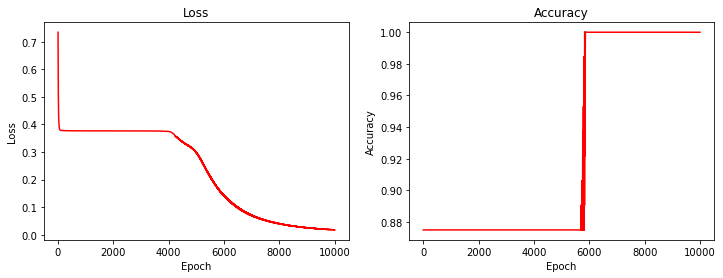

In [12]:
import matplotlib.pyplot as plt
# plot
fig, axes = plt.subplots(1,2, figsize=(12,4))
_ = axes[0].plot(loss_vec, 'r')
_ = axes[0].set_xlabel("Epoch")
_ = axes[0].set_ylabel("Loss")
_ = axes[0].set_title("Loss")
_ = axes[1].plot(acc_vec[10:],'r')
_ = axes[1].set_xlabel("Epoch")
_ = axes[1].set_ylabel("Accuracy")
_ = axes[1].set_title("Accuracy")

In [13]:
for param_name, param in model.state_dict().items():
    print(param_name, param)

layer1.weight tensor([[-1.5731,  0.7933, -3.1037,  3.1038, -0.7925,  1.5735],
        [-2.3407,  1.1806, -4.6229,  4.6249, -1.1778,  2.3418]])
layer1.bias tensor([1.1398, 0.0020])
layer2.weight tensor([[-3.6358,  5.4006],
        [ 3.6268, -5.0612]])
layer2.bias tensor([ 3.0788, -2.5044])


The results perfectly resembles what was obtained in the paper. The weights are indeed symmetric. The accuracy reached on the test set is 1.0. However, the number of epochs needed to get to this result is much higher than what was indicated in the paper (around 6000 instead od 1425).